In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pickle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import emcee
import corner


In [10]:
def dipole_cal(g, ra, dec, l=264, b=48):
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    phi = ra
    theta = np.pi/2-np.array(dec)

    nx = np.cos(phi)*np.sin(theta)
    ny = np.sin(phi)*np.sin(theta)
    nz = np.cos(theta)

    dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

    return dipole

from scipy.integrate import cumtrapz
from scipy.optimize import fmin
from scipy.interpolate import interp1d, UnivariateSpline

class confidence_interval(object):
    def __init__(self, posterior, param, level=0.683, verbose=False):
        self.posterior = posterior
        self.param = param
        self.level = level
        self.verbose = verbose
        self.lower_level, self.upper_level = self.HDI()
        self.interval = self.upper_level - self.lower_level
        self.map = self.MAP()
        
    def HDI(self):
        cdfvals = cumtrapz(self.posterior, self.param)
        sel = cdfvals > 0.
        x = self.param[1:][sel]
        cdfvals = cdfvals[sel]
        ppf = interp1d(cdfvals, x, fill_value=0., bounds_error=False)

        def intervalWidth(lowTailPr):
            ret = ppf(self.level + lowTailPr) - ppf(lowTailPr)
            if (ret > 0.):
                return ret
            else:
                return 1e4
        HDI_lowTailPr = fmin(intervalWidth, 1. - self.level, disp=self.verbose)[0]
        return ppf(HDI_lowTailPr), ppf(HDI_lowTailPr + self.level)

    def MAP(self):
        sp = UnivariateSpline(self.param, self.posterior, s=0.)
        x_highres = np.linspace(self.param[0], self.param[-1], 100000)
        y_highres = sp(x_highres)
        return x_highres[np.argmax(y_highres)]


In [11]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BBH/GW_injections_XG.p", "rb")
XG_BBH_inj = pickle.load(fr)
fr.close()

In [12]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/NSBH/GW_injections_XG.p", "rb")
XG_NSBH_inj = pickle.load(fr)
fr.close()

In [13]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BNS/GW_injections_XG.p", "rb")
XG_BNS_inj = pickle.load(fr)
fr.close()

In [14]:
dl_0_BBH = XG_BBH_inj['injections_parameters']['dls']
dl_0_NSBH = XG_NSBH_inj['injections_parameters']['dls']
dl_0_BNS = XG_BNS_inj['injections_parameters']['dls']

In [15]:
index_BBH = []
index_NSBH = []
index_BNS = []

for i in range(len(dl_0_BBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/BBH_cov_{i}.txt')
        if len(XG_BBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BBH[i]<461:
            index_BBH.append(i)
    except:
        continue

for i in range(len(dl_0_NSBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/NSBH_cov_{i}.txt')
        if len(XG_NSBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_NSBH[i]<461:
            index_NSBH.append(i)
    except:
        continue

for i in range(len(dl_0_BNS)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/BNS_cov_{i}.txt')
        if len(XG_BNS_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BNS[i]<461:
            index_BNS.append(i)
    except:
        continue


In [16]:
len(index_BBH),len(index_NSBH),len(index_BNS)

(33, 3, 3)

In [17]:
index_BBH

[1,
 2,
 3,
 7,
 8,
 9,
 14,
 15,
 16,
 17,
 18,
 21,
 22,
 24,
 27,
 28,
 29,
 30,
 32,
 33,
 36,
 37,
 39,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 53,
 54,
 57]

In [18]:
index_NSBH

[6, 23, 39]

In [19]:
index_BNS

[1, 40, 44]

In [20]:
# samples = [0]*(len(index_BBH)+len(index_NSBH)+len(index_BNS))
# for i,ind in enumerate(index_BBH):
#     samples[i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p0001/BBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_NSBH):
#     samples[len(index_BBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p0001/NSBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_BNS):
#     samples[len(index_BBH)+len(index_NSBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p0001/BNS_Fisher_samples_{ind}.dat', names=True)


In [21]:
index_all = np.append(np.append(np.array(index_BBH),np.array(index_NSBH)),np.array(index_BNS))

In [22]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['ra']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['ra']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [23]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['dec']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['dec']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [24]:
# ra_std = [0]*len(index_all)
# dec_std = [0]*len(index_all)
# ra_mean = [0]*len(index_all)
# dec_mean = [0]*len(index_all)
# for i in range(len(index_all)):
#     ra_std[i] = np.std(samples[i]['ra'])
#     dec_std[i] = np.std(samples[i]['dec'])
#     ra_mean[i] = np.mean(samples[i]['ra'])
#     dec_mean[i] = np.mean(samples[i]['dec'])

In [25]:
zs = [0]*len(index_all)
ra_mean = [0]*len(index_all)
dec_mean = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    zs[i] = XG_BBH_inj['injections_parameters']['zs'][ind]
    ra_mean[i] = XG_BBH_inj['injections_parameters']['ras'][ind]
    dec_mean[i] = XG_BBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_NSBH):
    zs[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_BNS):
    zs[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['decs'][ind]

In [26]:
g=0.0001

z0 = [0]*len(index_all)
for i,ind in enumerate(index_BBH):
    z0[i] = (1+zs[i]) * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_NSBH):
    z0[len(index_BBH)+i] = (1+zs[len(index_BBH)+i]) * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_BNS):
    z0[len(index_BBH)+len(index_NSBH)+i] = (1+zs[len(index_BBH)+len(index_NSBH)+i]) * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) -1

In [27]:
ra_std = [0]*len(index_all)
dec_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/BBH_cov_{ind}.txt')
    ra_std[i] = np.sqrt(data[4,4])
    dec_std[i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_NSBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/NSBH_cov_{ind}.txt')
    ra_std[len(index_BBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_BNS):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/BNS_cov_{ind}.txt')
    ra_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[5,5])    

In [28]:
np.array(ra_std)/np.pi*180

array([0.04303812, 0.02021798, 0.09839213, 0.01243849, 0.0224224 ,
       0.0351875 , 0.01938652, 0.02037263, 0.02875655, 0.03027343,
       0.01937844, 0.03422932, 0.04336638, 0.05157571, 0.04770477,
       0.09900628, 0.03153777, 0.06636428, 0.0186928 , 0.01820346,
       0.01220201, 0.01698528, 0.03380145, 0.01431089, 0.03273716,
       0.07689735, 0.02246908, 0.0502644 , 0.00475751, 0.04039674,
       0.0388857 , 0.0245366 , 0.06469764, 0.03827493, 0.05354287,
       0.06895162, 0.07054832, 0.0192703 , 0.08482834])

In [29]:
np.array(dec_std)/np.pi*180

array([0.00736137, 0.15070653, 0.03408064, 0.0425899 , 0.02044134,
       0.01190396, 0.02515636, 0.01452244, 0.0281141 , 0.00641228,
       0.01990916, 0.05564041, 0.07612   , 0.04158372, 0.04855422,
       0.01891232, 0.02253342, 0.01921463, 0.01869526, 0.04049511,
       0.15777468, 0.03055654, 0.03424582, 0.02042927, 0.03145124,
       0.01746996, 0.01181531, 0.0585483 , 0.00368626, 0.01145254,
       0.02674973, 0.00692946, 0.01408273, 0.04651676, 0.0411253 ,
       0.04209378, 0.05061939, 0.09890132, 0.03487312])

In [65]:
16*np.array(ra_std)/np.pi*180*np.array(dec_std)/np.pi*180

array([0.00506911, 0.04875171, 0.05365227, 0.00847606, 0.0073335 ,
       0.00670193, 0.00780311, 0.00473377, 0.01293543, 0.00310595,
       0.00617293, 0.03047254, 0.05281678, 0.03431536, 0.03706029,
       0.02995902, 0.01137046, 0.02040264, 0.00559147, 0.01179442,
       0.0308027 , 0.00830419, 0.01852093, 0.00467778, 0.01647399,
       0.0214943 , 0.00424767, 0.04708633, 0.0002806 , 0.00740232,
       0.01664291, 0.0027204 , 0.01457791, 0.02848681, 0.03523147,
       0.04643895, 0.0571378 , 0.03049373, 0.04733166])

In [31]:
dl_mean = [0]*len(index_all)
dl_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    dl_mean[i] = dl_0_BBH[ind] * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/BBH_cov_{ind}.txt')
    dl_std[i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_NSBH):
    dl_mean[len(index_BBH)+i] = dl_0_NSBH[ind] * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/NSBH_cov_{ind}.txt')
    dl_std[len(index_BBH)+i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_BNS):
    dl_mean[len(index_BBH)+len(index_NSBH)+i] = dl_0_BNS[ind] * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) 
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0001/BNS_cov_{ind}.txt')
    dl_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[2,2])
 
    # dl_mean[i] = np.mean(samples[i]['luminosity_distance'])
    # dl_std[i] = np.std(samples[i]['luminosity_distance'])

In [32]:
def chi2_dl_dipole(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]
    
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    chi2 = 0

    for i in range(len(ra_arr)):
        phi = ra_arr[i]
        theta = np.pi/2-np.array(dec_arr[i])

        nx = np.cos(phi)*np.sin(theta)
        ny = np.sin(phi)*np.sin(theta)
        nz = np.cos(theta)

        dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

        astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
        zt = (1+zs_arr[i])/(1+dipole) -1
        dl_0 = astropy_cosmology.luminosity_distance(zt).value
        dl_g = dl_0*(1+dipole)

        chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2

    return chi2


In [33]:
chi2_dl_dipole([1.250e-04, 268, 48], ra_mean, dec_mean, z0, dl_mean, dl_std, H0=70, Om0=0.3)

0.4679967844178544

In [34]:
minimize(chi2_dl_dipole, [0,268,48], args=(ra_mean, dec_mean, z0, dl_mean, dl_std), method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.1467935812166366e-12
             x: [ 1.000e-04  2.640e+02  4.800e+01]
           nit: 99
          nfev: 184
 final_simplex: (array([[ 1.000e-04,  2.640e+02,  4.800e+01],
                       [ 1.000e-04,  2.640e+02,  4.800e+01],
                       [ 1.000e-04,  2.640e+02,  4.800e+01],
                       [ 1.000e-04,  2.640e+02,  4.800e+01]]), array([ 1.147e-12,  2.222e-12,  2.255e-12,  2.359e-12]))

In [35]:
# cov_index = [0]*len(index)
# for i,ind in enumerate(index):
#     cov_data = np.loadtxt(f'covariance_XG_snr500/cov_{ind}.txt')
#     cov_index[i] = np.zeros((3,3))
#     cov_index[i][0,0] = cov_data[2,2]
#     cov_index[i][0,1:] = cov_data[2,4:]
#     cov_index[i][1:,0] = cov_data[4:,2]
#     cov_index[i][1:,1:] = cov_data[4:,4:]

In [36]:
def logprob_dl_g(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            # x = np.array([dl_g, ra_arr[i], dec_arr[i]])
            # mu = np.array([dl_mean[i], ra_arr[i], dec_arr[i]])
            # diff = x - mu
            
            # chi2 += np.dot(diff, np.linalg.solve(cov_matrix, diff))
            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob


In [37]:
nwalkers = 32
ndim = 3
p0 = np.random.rand(nwalkers, ndim)*np.array([1,360,180]) - np.array([0,0,90])
print(p0)

[[ 2.83146154e-01  1.94120672e+02  2.39130889e+01]
 [ 1.53606350e-02  3.15149200e+02  2.62946640e+01]
 [ 1.29345734e-01  1.58498077e+02  8.19496384e+01]
 [ 8.62678135e-01  1.46326916e+02 -8.23514458e+01]
 [ 2.46021503e-02  3.53306373e+02  8.96899108e+01]
 [ 5.70481942e-01  9.25265032e+01  2.78397395e+01]
 [ 3.83909881e-01  1.95641116e+02  1.53569581e+01]
 [ 8.56762339e-01  2.45493833e+02  3.53871379e+01]
 [ 4.54381048e-01  1.98771923e+02 -4.00202374e+01]
 [ 1.79530607e-01  3.42792311e+02  5.01386042e+01]
 [ 6.03982784e-01  2.30311970e+02  8.91685620e+01]
 [ 8.36486438e-01  1.91047788e+02 -1.01878592e+00]
 [ 5.58689413e-01  1.78729114e+02 -1.38070389e+01]
 [ 1.12128634e-01  1.77848215e+02  5.67230966e+01]
 [ 2.72103543e-01  1.40848521e+02  2.54452115e+01]
 [ 5.88113410e-01  3.45178527e+02  5.44945167e+01]
 [ 4.08425577e-02  1.82726315e+02  8.49116781e+01]
 [ 7.05675657e-01  8.17658593e+01 -4.73575686e+01]
 [ 9.01198879e-01  6.19786441e+01  7.35937022e+01]
 [ 1.98516312e-01  3.07960816e+

In [38]:
logprob_dl_g(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-19555525.530366417

In [39]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [40]:
state = sampler.run_mcmc(p0, 100)
# sampler.reset()

(array([1.984e+03, 2.030e+02, 1.370e+02, 1.250e+02, 1.090e+02, 5.200e+01,
        2.600e+01, 3.300e+01, 3.200e+01, 1.100e+01, 1.000e+01, 2.000e+01,
        1.300e+01, 2.200e+01, 1.600e+01, 1.500e+01, 1.200e+01, 1.200e+01,
        1.000e+01, 1.200e+01, 2.000e+00, 8.000e+00, 1.700e+01, 2.000e+00,
        6.000e+00, 4.000e+00, 1.900e+01, 1.100e+01, 5.000e+00, 4.000e+00,
        1.400e+01, 2.000e+01, 1.600e+01, 4.000e+00, 2.000e+00, 5.000e+00,
        9.000e+00, 5.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        7.000e+00, 8.000e+00, 7.000e+00, 2.000e+00, 3.000e+00, 8.000e+00,
        9.000e+00, 5.000e+00, 7.000e+00, 2.000e+00, 1.000e+00, 5.000e+00,
        7.000e+00, 1.400e+01, 0.000e+00, 1.000e+00, 1.000e+01, 2.000e+00,
        7.000e+00, 6.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        5.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 3.000e+0

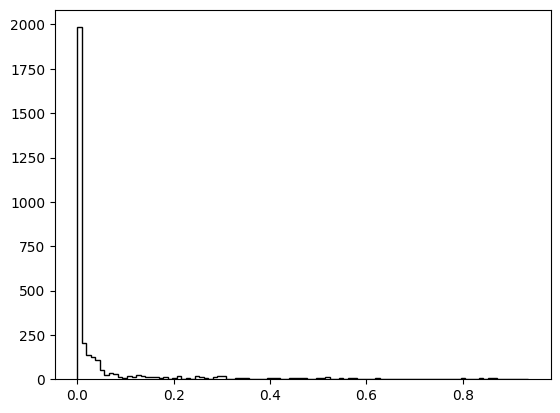

In [41]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

(array([20.,  9., 29.,  1., 10.,  9.,  9., 13.,  5.,  1.,  2.,  6.,  8.,
         0., 14.,  6.,  3.,  5., 12., 12., 13., 15., 12.,  8., 14., 20.,
        30., 12., 11., 15.,  8.,  8., 39., 15., 30., 30., 37.,  7., 22.,
        24., 18., 40., 13., 39., 21., 21., 37., 59., 54., 64., 77., 77.,
        63., 71., 50., 63., 49., 41., 67., 54., 47., 69., 45., 52., 39.,
        63., 54., 70., 62., 55., 85., 32., 53., 67., 57., 49., 45., 51.,
        23., 26., 32., 45., 28., 10., 64., 39., 33., 30., 50., 61.,  5.,
        15., 46., 33., 14., 23., 28., 16., 37., 25.]),
 array([  1.1713203 ,   4.75129358,   8.33126686,  11.91124014,
         15.49121342,  19.0711867 ,  22.65115998,  26.23113326,
         29.81110654,  33.39107982,  36.9710531 ,  40.55102638,
         44.13099966,  47.71097294,  51.29094622,  54.8709195 ,
         58.45089278,  62.03086606,  65.61083934,  69.19081262,
         72.7707859 ,  76.35075918,  79.93073246,  83.51070574,
         87.09067902,  90.6706523 ,  94.25062558, 

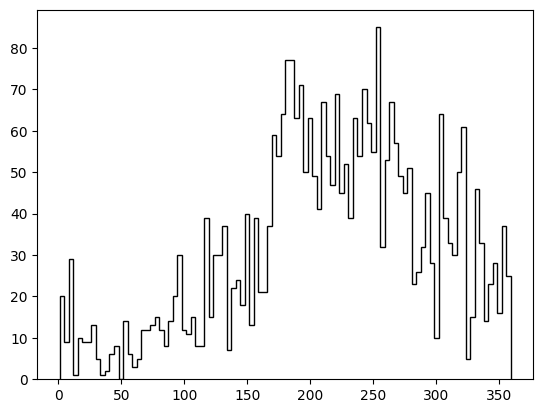

In [42]:
plt.hist(samples[:, 1], 100, color="k", histtype="step")

In [43]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[ 8.25351317e-05  3.35336551e+02  6.79197643e+01]
 [ 6.38282786e-05  2.68074340e+02 -3.22486426e+01]
 [ 8.68024712e-05  1.49791070e+01  7.47503371e+01]
 [ 8.62414213e-05  1.86972686e+02  3.14434166e+01]
 [ 1.30842941e-04  2.57408049e+02  6.16994230e+01]
 [ 1.15608479e-04  3.33837521e+02  7.43255640e+01]
 [ 1.11102014e-04  2.15716395e+02  2.59920410e+01]
 [ 7.11727091e-05  3.43483053e+02  8.98441458e+01]
 [ 1.76657465e-05  4.87767525e+01  7.50178771e+01]
 [ 8.87584734e-05  2.41105705e+02 -1.18317306e+01]
 [ 9.94347512e-05  1.82945396e+02  8.29408503e+01]
 [ 1.71837217e-04  3.22326002e+02  6.72005364e+01]
 [ 9.35523402e-05  2.47107145e+02  5.37111627e+01]
 [ 5.69964772e-05  2.33081262e+02  5.44031455e+01]
 [ 1.47276781e-04  1.61444572e+02  5.82677569e+01]
 [ 7.49016245e-05  2.37875802e+02  8.78211714e+01]
 [ 1.38052073e-04  2.79317313e+02  9.29090770e+00]
 [ 8.60528156e-07  8.08875162e+01  6.20879959e+01]
 [ 4.59422699e-05  2.97182275e+02  6.86352555e+01]
 [ 1.23777584e-04  2.3315

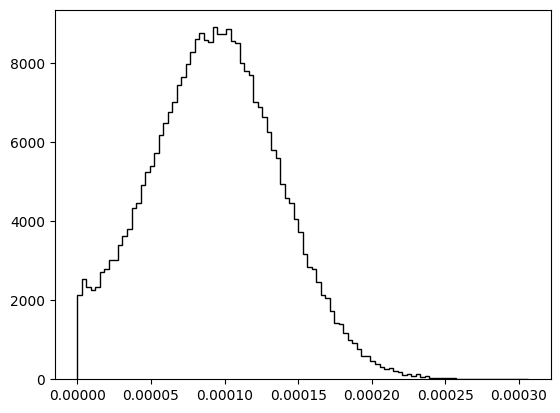

In [44]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.savefig('../plots/emcee_dip_g0p0001.png',dpi=600)

In [45]:
np.savetxt('emcee_sample_dip_g0p0001.txt',samples)

In [46]:
# samples = np.loadtxt('emcee_sample_dip_g0p005.txt')

In [47]:
samples[:,0]*=1e4

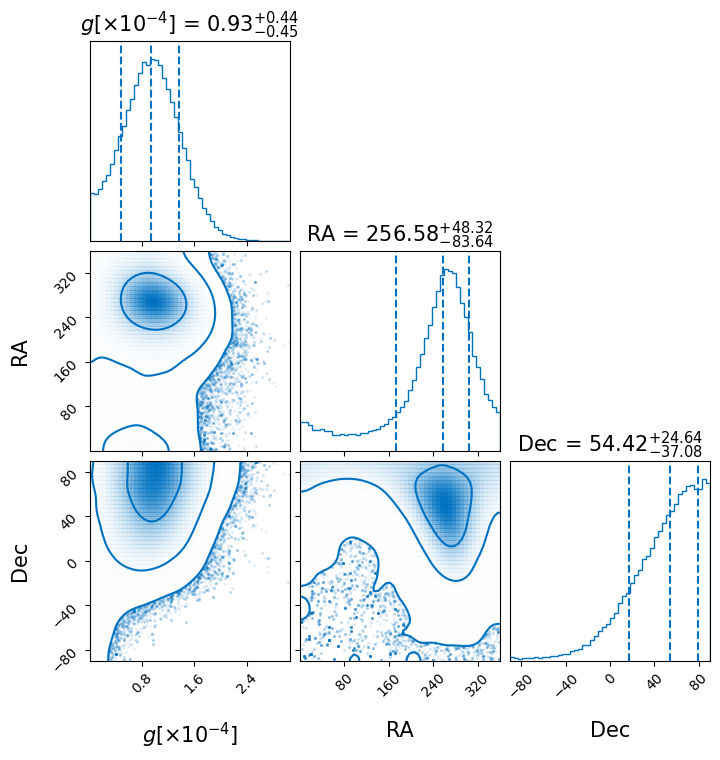

In [48]:
labels=[r'$g[\times 10^{-4}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p0001_corner.pdf',bbox_inches='tight')

In [49]:
# samples = np.loadtxt('emcee_sample_dip_g0p005.txt')

In [50]:
sample_hist = np.histogram(samples[:,0],bins=500)

In [51]:
from scipy.integrate import simps
cdi = confidence_interval(sample_hist[0]/simps(sample_hist[0],sample_hist[1][:-1]), sample_hist[1][:-1])

/tmp/ipykernel_153934/3624433521.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cdi = confidence_interval(sample_hist[0]/simps(sample_hist[0],sample_hist[1][:-1]), sample_hist[1][:-1])
/tmp/ipykernel_153934/1663745354.py:38: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdfvals = cumtrapz(self.posterior, self.param)


In [52]:
print(cdi.MAP(), cdi.upper_level-cdi.MAP(), cdi.MAP()-cdi.lower_level)

0.8396599542604606 0.5259898784631722 0.3678542695307976


In [53]:
def logprob_dl_g_H0(H0glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, Om0=0.3):
    H0 = H0glb[0]
    g = H0glb[1]
    l = H0glb[2]
    b = H0glb[3]

    if 0<=g<1 and 0<l<=360 and -90<=b<=90 and 10<H0<200:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob

In [54]:
nwalkers = 32
ndim = 4
p0 = np.random.rand(nwalkers, ndim)*np.array([190,1,360,180]) - np.array([-10,0,0,90])
print(p0)

[[ 1.34615337e+02  8.52911221e-01  3.03309187e+01  8.26905403e+01]
 [ 1.68526249e+02  4.67915568e-01  1.37569795e+02 -8.39086657e+00]
 [ 8.71702950e+01  5.26973778e-01  5.21400556e+01 -3.21697869e+00]
 [ 5.11741769e+01  2.91608806e-01  1.59562637e+01 -5.13761889e+01]
 [ 1.17162179e+01  2.67080380e-01  1.00982061e+02 -7.62047205e+01]
 [ 1.56510585e+02  5.44602290e-01  3.47101862e+02 -3.21201196e+01]
 [ 6.85091866e+01  5.60035616e-02  1.40792804e+02 -2.45989535e+00]
 [ 1.30005664e+02  2.67520768e-01  3.00977253e+02  1.62807647e+01]
 [ 9.88922415e+01  4.64654331e-01  3.26183043e+02 -4.39983752e+01]
 [ 1.22410752e+02  8.83317163e-01  2.60005999e+02 -5.20977530e+01]
 [ 1.24974075e+02  8.10112682e-01  2.01556468e+02  8.40293670e+01]
 [ 7.54539956e+01  1.30236028e-01  1.35709209e+02  8.23450496e+01]
 [ 1.34969357e+02  5.54379866e-01  1.19809821e+02  7.07590444e+01]
 [ 1.96853928e+02  9.00365066e-02  2.61786964e+02  8.24157021e+01]
 [ 1.03454568e+02  8.42741047e-01  2.37310530e+02  7.95738446e

In [55]:
logprob_dl_g_H0(p0[0], ra_mean, dec_mean, zs, dl_mean, dl_std)

-86539121.27939549

In [56]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g_H0, args=[ra_mean, dec_mean, zs, dl_mean, dl_std])


In [57]:
state = sampler.run_mcmc(p0, 100)


(array([  1.,   7.,   0.,   3.,   3.,   5.,   0.,   3.,  16.,   0.,   2.,
          5.,   1.,   6.,   6.,   1.,  16.,   4.,  41.,  12., 170., 314.,
        467., 304., 151., 130.,  90.,  49.,  49.,  51.,  18.,  56.,  28.,
         29.,  25.,  18.,  60.,  15.,  28.,  57.,  40.,  31.,  40.,  30.,
         30.,   9.,  16.,  18.,  34.,  12.,  12.,   1.,  22.,  63.,  10.,
          8.,  30.,  11.,  30.,  11.,   5.,  20.,  10.,  10.,  22.,  17.,
         10.,  30.,  37.,  18.,  15.,  11.,   9.,  14.,   3.,  26.,   6.,
          0.,  38.,   0.,   8.,  14.,   5.,  21.,   0.,  31.,   7.,   0.,
         15.,   0.,   0.,   0.,  11.,   0.,   9.,   7.,   2.,  41.,   8.,
         21.]),
 array([ 32.31286511,  33.98893929,  35.66501348,  37.34108767,
         39.01716185,  40.69323604,  42.36931023,  44.04538441,
         45.7214586 ,  47.39753279,  49.07360697,  50.74968116,
         52.42575535,  54.10182953,  55.77790372,  57.45397791,
         59.13005209,  60.80612628,  62.48220047,  64.15827465

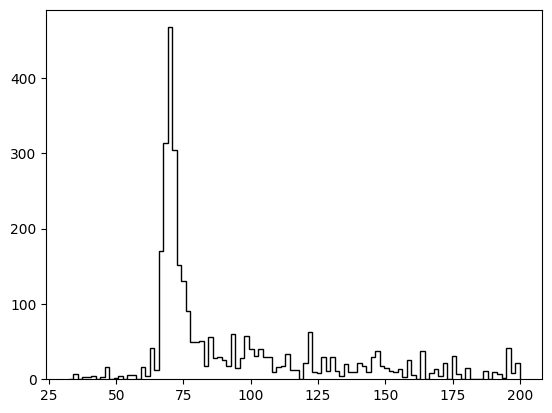

In [58]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

In [59]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[ 7.00995365e+01  1.68446228e-05  2.91842068e+02 -6.66887295e+01]
 [ 7.00219663e+01  3.66227448e-05  2.18101808e+02 -6.70713841e+01]
 [ 7.00029727e+01  1.10202647e-05  9.68692794e+01  8.45382397e+01]
 [ 6.99754148e+01  1.87414149e-05  1.73236342e+02  6.85404721e+00]
 [ 7.00295537e+01  4.34998963e-05  1.39399110e+02  3.13553108e+00]
 [ 7.00114324e+01  3.29247285e-05  2.62674270e+02 -3.77825394e+01]
 [ 6.99979613e+01  1.20607774e-05  1.85924278e+01  7.93406396e+01]
 [ 7.00959082e+01  1.29330357e-04  1.56057588e+02 -2.60283371e+01]
 [ 6.99517528e+01  5.51943989e-05  2.32694409e+02  7.63062552e+01]
 [ 6.99820445e+01  3.14570534e-05  6.58416080e+01  2.62895679e+01]
 [ 6.99611958e+01  5.51716063e-05  7.28330157e+01  8.01935014e+01]
 [ 7.00285596e+01  2.48841318e-05  4.68263007e+01 -8.16110983e+01]
 [ 6.99864489e+01  5.06285234e-07  2.40621546e+02  1.22113965e+00]
 [ 7.00588875e+01  4.42540078e-05  1.73902295e+02  1.42115686e+01]
 [ 6.99025859e+01  6.16265307e-05  2.39951004e+02  5.224

Text(0, 0.5, 'Count')

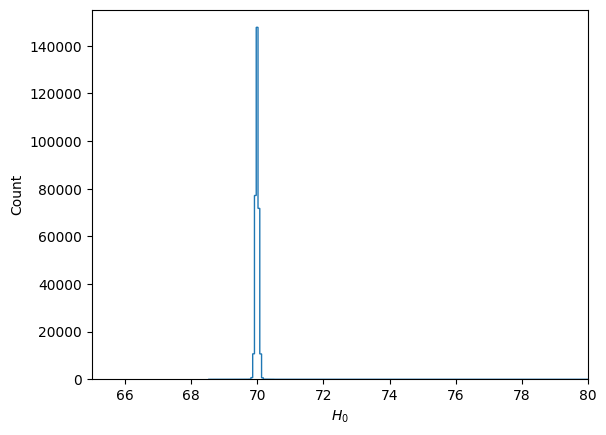

In [60]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 1000, histtype="step")
plt.xlim(65,80)
plt.xlabel(r'$H_0$')
plt.ylabel('Count')

In [61]:
np.savetxt('emcee_sample_dip_g0p0001_H0.txt',samples)

In [62]:
samples = np.loadtxt('emcee_sample_dip_g0p0001_H0.txt')

In [63]:
samples[:,1]*=1e4

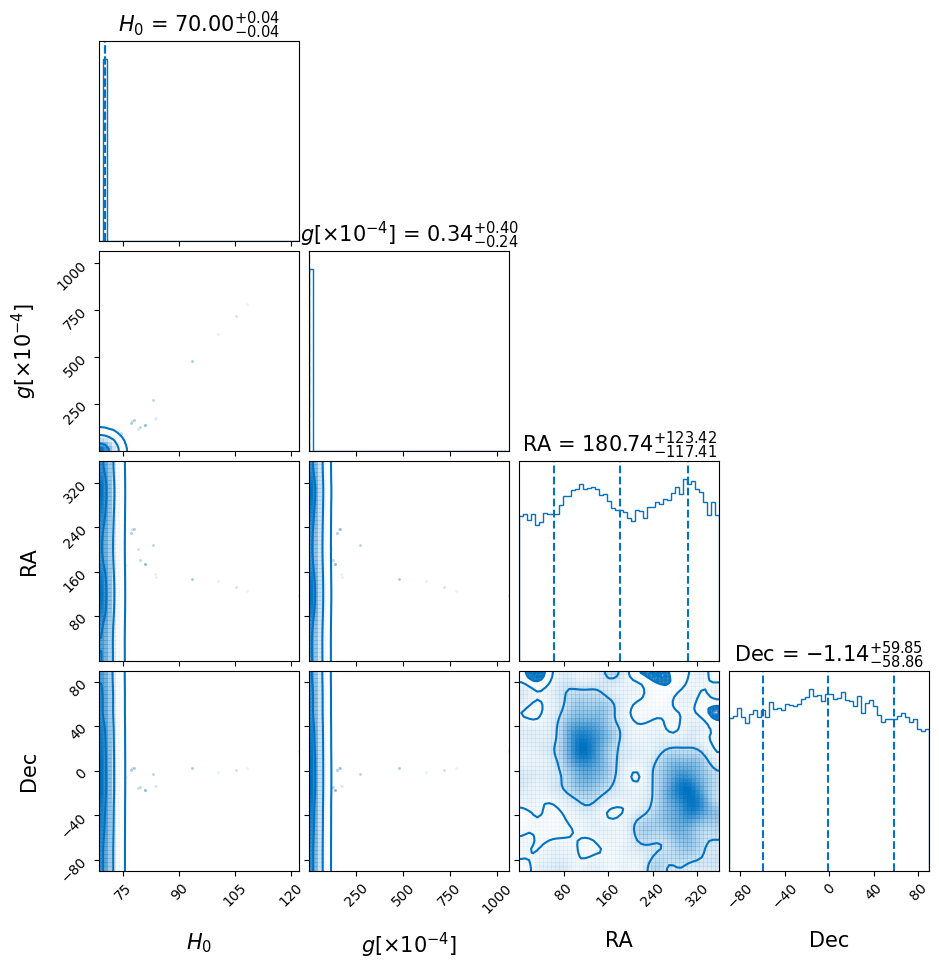

In [64]:
labels=[r'$H_0$',r'$g[\times 10^{-4}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p0001_H0_corner.pdf',bbox_inches='tight')